# Name: Aadit Harshal Baldha
# Batch: Fall 2024 (2nd Sem)
# CWID: 20029691

## Topic: ML: Fundamentals and Applications Project Individual Work for Cluster Group #0

### 3.3 Building the Training Model

#### 3.3.1 Creating the Classification Model

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
clustered_df = pd.read_csv('output/clustered_data.csv')

# Define features and labels
X_full = clustered_df.drop(columns=['Cluster'])
y = clustered_df['Cluster']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, stratify=y, random_state=42
)

# Model initialization
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Evaluation
y_pred = grid_search.best_estimator_.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Full Feature Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save feature importances
feature_importances = pd.Series(
    grid_search.best_estimator_.feature_importances_,
    index=X_full.columns
).sort_values(ascending=False)
feature_importances.to_csv("output/feature_importances_full.csv")

# Automatically select optimal top-N features
top_all_features = feature_importances.index.tolist()
performance_records = []

for top_n in range(5, min(41, len(top_all_features) + 1)):
    selected_features = top_all_features[:top_n]
    X_selected = clustered_df[selected_features]

    xgb_n = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(y.unique()),
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    )

    grid_n = GridSearchCV(xgb_n, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=0)
    grid_n.fit(X_selected, y)

    cv_result_n = cross_validate(grid_n.best_estimator_, X_selected, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print(cv_result_n)
    mean_acc = cv_result_n['test_score'].mean()
    performance_records.append((top_n, mean_acc, grid_n.best_params_))

# Best configuration
best_n, best_acc, best_params = max(performance_records, key=lambda x: x[1])
print(f"\n✅ Best number of features: {best_n}")
print(f"✅ Highest Mean CV Accuracy: {best_acc:.4f}")
print(f"✅ Best Params: {best_params}")

# Save top-N feature list
best_features = top_all_features[:best_n]
pd.Series(best_features).to_csv("output/best_top_features.csv", index=False)

# Save performance summary
pd.DataFrame(performance_records, columns=['Top_N_Features', 'CV_Accuracy', 'Best_Params']) \
  .to_csv("output/feature_selection_performance.csv", index=False)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


<Figure size 1200x800 with 0 Axes>

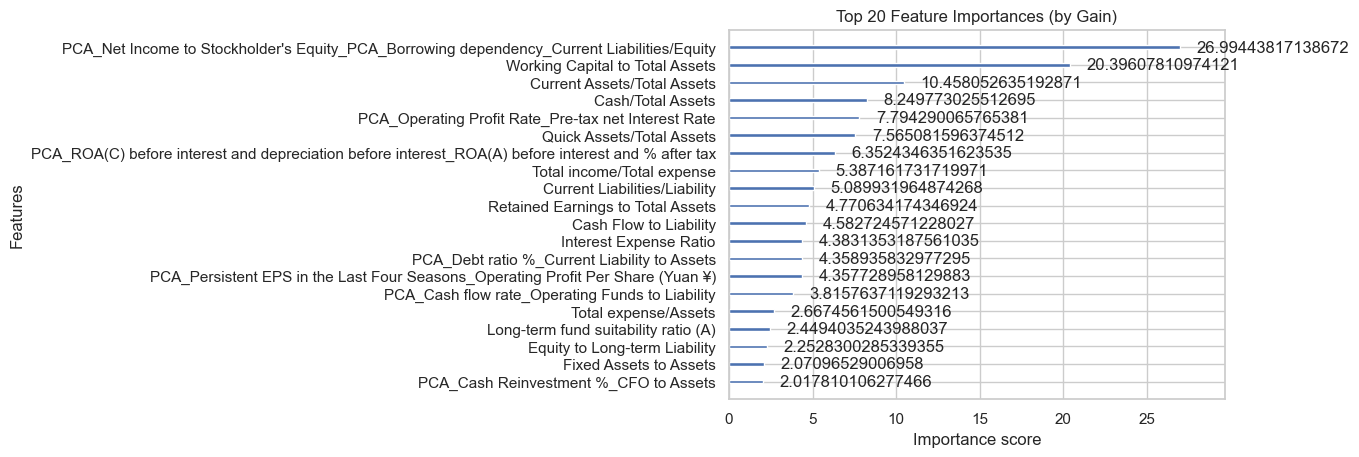

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(best_model, importance_type='gain', max_num_features=20)
plt.title('Top 20 Feature Importances (by Gain)')
plt.show()


Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\aadit\Anaconda\envs\AaHB_CS556B_Env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:23:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters (Reduced): {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       311
           1       0.94      0.96      0.95       470
           2       0.95      0.94      0.95       381

    accuracy                           0.95      1162
   macro avg       0.95      0.95      0.95      1162
weighted avg       0.95      0.95      0.95      1162



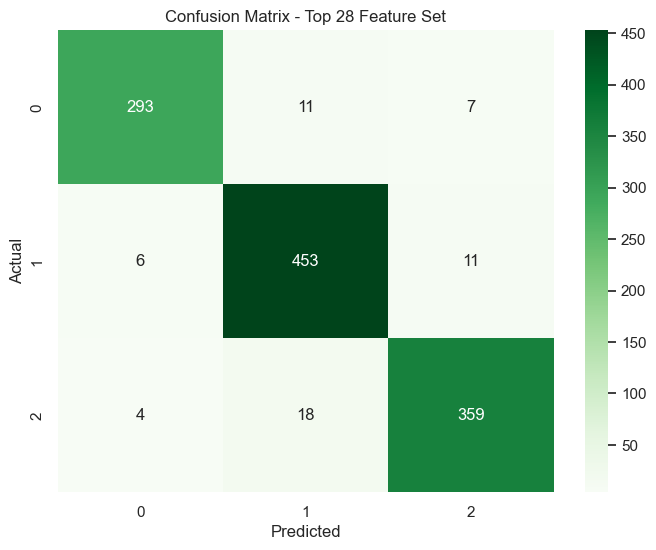


Cross-Validation Results (Top 28 Feature Set):
Mean Accuracy: 0.9528 ± 0.0040
Mean Precision (Macro): 0.9540 ± 0.0037
Mean Recall (Macro): 0.9524 ± 0.0043
Mean F1-score (Macro): 0.9531 ± 0.0039


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
clustered_df = pd.read_csv('output/clustered_data.csv')

# Load top 28 important features
top_features = pd.read_csv("output/top_28_features.csv", index_col=0).index.tolist()

# Use only top features
X_reduced = clustered_df[top_features]

# Reuse target variable
y = clustered_df['Cluster']

# Train-test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)

# Reinitialize model
xgb_reduced = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Same parameter grid as before
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid_search_r = GridSearchCV(xgb_reduced, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
grid_search_r.fit(X_train_r, y_train_r)

# Evaluation
y_pred_r = grid_search_r.best_estimator_.predict(X_test_r)
print("Best Parameters (Reduced):", grid_search_r.best_params_)
print(classification_report(y_test_r, y_pred_r))

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_r, y_pred_r), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Top 28 Feature Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Cross-validation metrics
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_results_r = cross_validate(
    grid_search_r.best_estimator_, X_reduced, y,
    cv=cv, scoring=scoring, n_jobs=-1
)

# Display cross-validation results
print("\nCross-Validation Results (Top 28 Feature Set):")
print(f"Mean Accuracy: {cv_results_r['test_accuracy'].mean():.4f} ± {cv_results_r['test_accuracy'].std():.4f}")
print(f"Mean Precision (Macro): {cv_results_r['test_precision_macro'].mean():.4f} ± {cv_results_r['test_precision_macro'].std():.4f}")
print(f"Mean Recall (Macro): {cv_results_r['test_recall_macro'].mean():.4f} ± {cv_results_r['test_recall_macro'].std():.4f}")
print(f"Mean F1-score (Macro): {cv_results_r['test_f1_macro'].mean():.4f} ± {cv_results_r['test_f1_macro'].std():.4f}")



Test predictions saved to 'output/test_predictions_top28.csv'


#### 3.3.2 Building the Stacking Model

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Separate features and labels
X = clustered_df[clustered_df['Cluster']==0].drop(columns=['Bankrupt?'])  # Replace 'Bankrupt?' with your target column
y = clustered_df[clustered_df['Cluster']==0]['Bankrupt?']


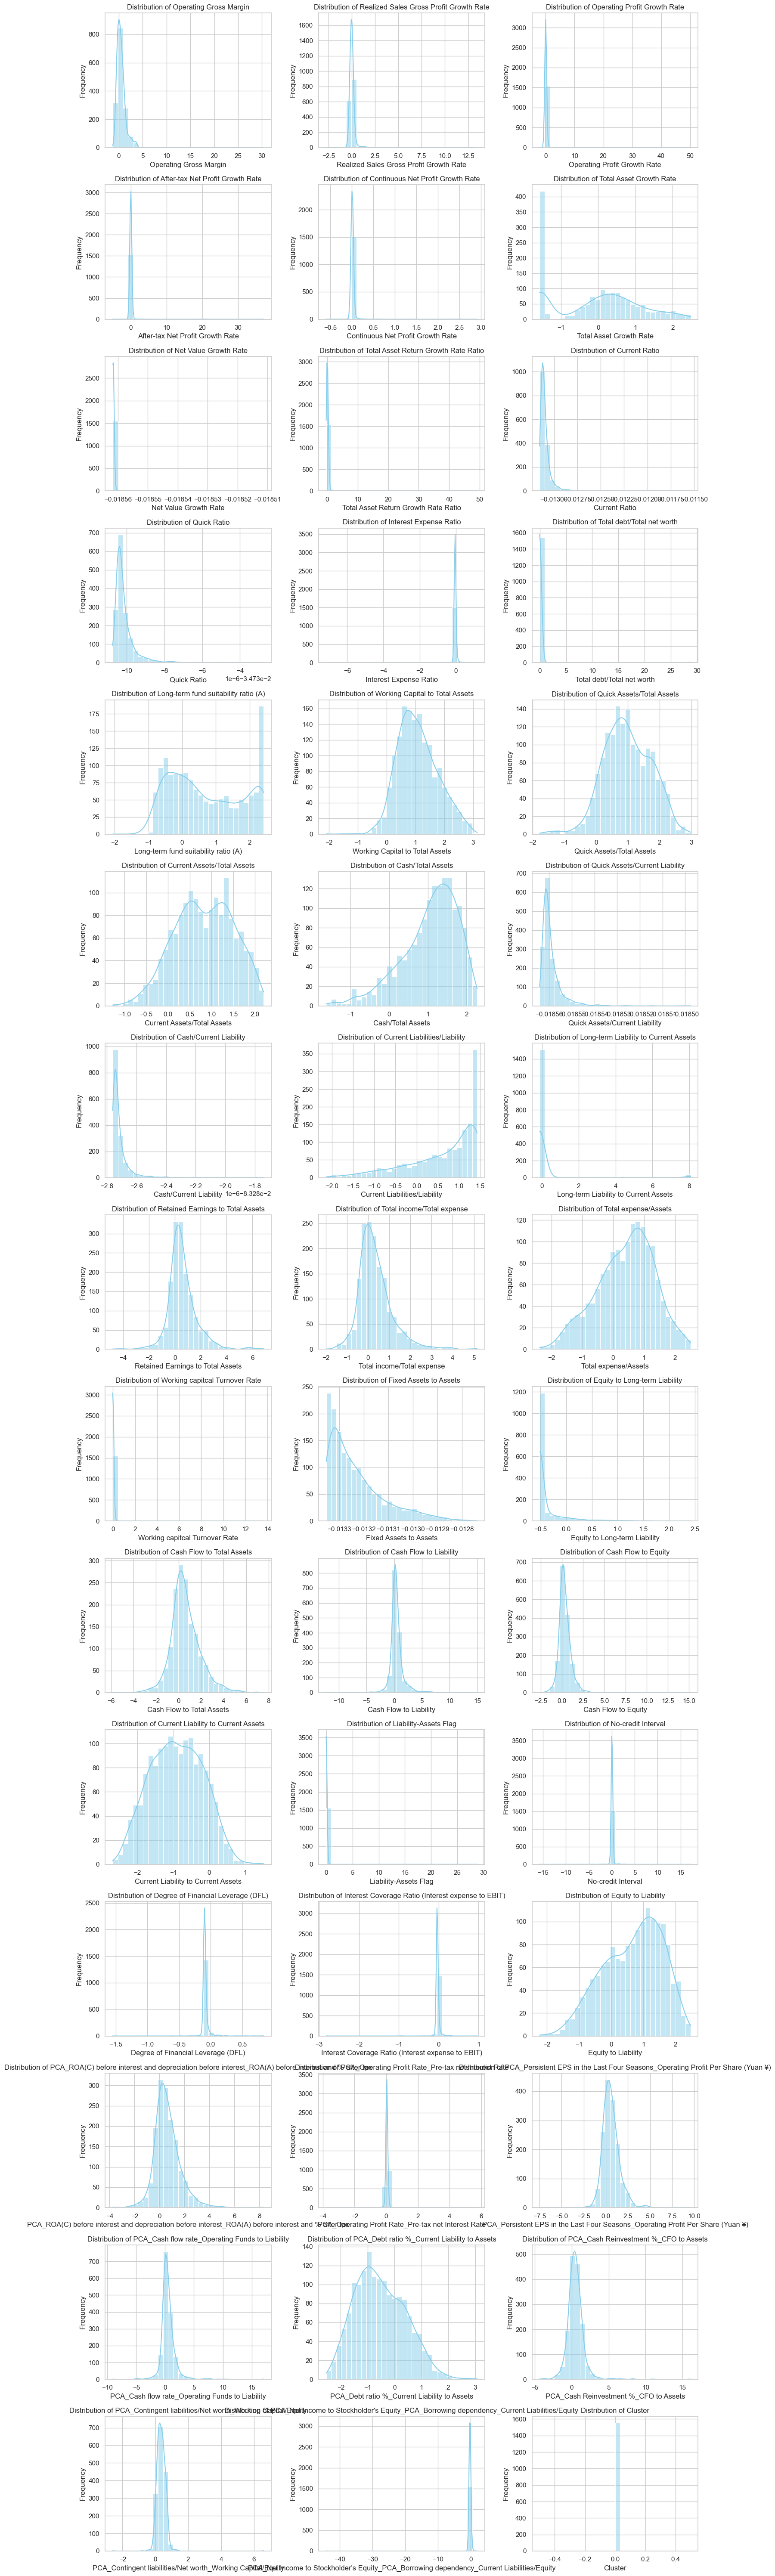

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style='whitegrid')

# Create subplots
num_features = X.shape[1]
cols = 3  # Number of columns in the subplot grid
rows = (num_features + cols - 1) // cols  # Calculate required rows

plt.figure(figsize=(cols * 5, rows * 4))

for i, col in enumerate(X.columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(X[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# 1. Define feature matrix X and target vector y
# X = <your feature matrix>
# y = <your labels>

# 2. Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 3. Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define hyperparameter grids
param_grid_dt = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

param_grid_knn = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 3]
}

# 5. Initialize models
models = {
    'dt': (DecisionTreeClassifier(random_state=42), param_grid_dt),
    'knn': (make_pipeline(StandardScaler(), KNeighborsClassifier()), param_grid_knn),
    'rf': (RandomForestClassifier(random_state=42), param_grid_rf),
    'xgb': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid_xgb)
}

# 6. Grid Search to find best base estimators
best_estimators = {}

for name, (model, param_grid) in models.items():
    print(f"Tuning {name.upper()}...")
    gs = GridSearchCV(model, param_grid, cv=cv_strategy, n_jobs=-1, scoring='recall')
    gs.fit(X_train, y_train)
    best_estimators[name] = gs.best_estimator_
    print(f"Best params for {name.upper()}: {gs.best_params_}")
    print(f"Best CV Recall: {gs.best_score_:.4f}")
    print("-" * 60)

# 7. Apply SMOTE to address class imbalance
smote = SMOTE(sampling_strategy='minority', random_state=42,k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 8. Build Stacking Classifier
stack_model = StackingClassifier(
    estimators=[(name, model) for name, model in best_estimators.items()],
    final_estimator=LogisticRegression(class_weight='balanced', random_state=42),
    cv=cv_strategy,
    n_jobs=-1,
    passthrough=False  # Turned off for safety against overfitting
)

# 9. Train Stacking Classifier on resampled data
stack_model.fit(X_train_resampled, y_train_resampled)

# 10. Evaluate on untouched test set
y_pred = stack_model.predict(X_test)

print("\nClassification Report for Stacked Model:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Stacked Model')
plt.show()


Tuning DT...


c:\Users\aadit\Anaconda\envs\AaHB_CS556B_Env\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best params for DT: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 2}
Best CV Recall: 0.0000
------------------------------------------------------------
Tuning KNN...


c:\Users\aadit\Anaconda\envs\AaHB_CS556B_Env\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best params for KNN: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'uniform'}
Best CV Recall: 0.0000
------------------------------------------------------------
Tuning RF...


c:\Users\aadit\Anaconda\envs\AaHB_CS556B_Env\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best params for RF: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Recall: 0.0000
------------------------------------------------------------
Tuning XGB...


c:\Users\aadit\Anaconda\envs\AaHB_CS556B_Env\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best params for XGB: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1}
Best CV Recall: 0.0000
------------------------------------------------------------


c:\Users\aadit\Anaconda\envs\AaHB_CS556B_Env\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:20:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\aadit\Anaconda\envs\AaHB_CS556B_Env\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 3, n_samples_fit = 2, n_samples = 2

In [ ]:
meta_model = LogisticRegression(random_state=42)


In [ ]:
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    passthrough=True,
    n_jobs=-1
)
stack_model.fit(X,y)

NameError: name 'base_models' is not defined

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(stack_model, X, y, cv=cv, method='predict')

acc = accuracy_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(cm)
